# Install Dependencies

In [2]:
%pip install langchain_openai==0.3.2 langgraph==0.2.68 langchain-community==0.3.16 langchain-experimental==0.3.4 langchain-core==0.3.32 ipython==8.31.0 httpx==0.28.1


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Setup Environment

In [3]:
import os

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

# Create Tools

In [4]:
import json
import httpx

from langchain_core.tools import tool


@tool
def get_players() -> str:
    """Use this to fetch real time details of players, team, country, salary etc."""

    result = httpx.Client().get('http://localhost:8081/players')
    return json.dumps(result.json())


@tool
def get_landmarks() -> str:
    """Use this to fetch real time details of places, landmarks etc."""

    result = httpx.Client().get('http://localhost:8081/landmarks')
    return json.dumps(result.json())


@tool
def get_trains() -> str:
    """Use this to fetch real time details of trains, locomotives classified from class M1 - M11."""

    result = httpx.Client().get('http://localhost:8081/trains')
    return json.dumps(result.json())

# Create Agents

In [60]:
from langchain_openai import ChatOpenAI
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

members = ['sport_agent', 'place_agent', 'train_agent']
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ['FINISH']

system_prompt = (
    f'''
    You are a supervisor tasked with You are a supervisor tasked with managing a conversation between the
    following workers: {members}. respond with the worker to act next. Each worker will perform a
    task and respond with their results and status. When finished, respond with FINISH.
    - If the question is about sports, players, or teams, route to `sport_agent`.
    - If the question is about places or landmarks, route to `place_agent`.
    - If the question is about trains, locomotives, or railway engines, route to `train_agent`.
    - If none of these apply, route to `FINISH`.
    '''
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatOpenAI(model='gpt-4o-mini')


class State(MessagesState):
    next: str


sport_agent = create_react_agent(
    llm, tools=[get_players], prompt='You are a sport agent. ONLY ANSWER SPORTS, PLAYERS, TEAMS RELATED QUESTIONS.'
)

place_agent = create_react_agent(
    llm, tools=[get_landmarks], prompt='You are a place agent. Answer questions related to places, landmarks etc.'
)

train_agent = create_react_agent(
    llm, tools=[get_trains],
    prompt='You are a train agent. answer question related to trains, engines, locomotives classified from M1 - M11).'
)


def supervisor_node(state: State) -> Command[Literal[*members, '__end__']]:
    messages = [
                   {'role': 'system', 'content': system_prompt},
               ] + state['messages']
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response['next']
    if goto == 'FINISH':
        goto = END

    return Command(goto=goto, update={'next': goto})


def sport_node(state: State) -> Command[Literal['supervisor']]:
    result = sport_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='sport_agent')
            ]
        },
        goto='supervisor',
    )


def place_node(state: State) -> Command[Literal['supervisor']]:
    result = place_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='place_agent')
            ]
        },
        goto='supervisor',
    )


def train_node(state: State) -> Command[Literal['supervisor']]:
    result = train_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='train_agent')
            ]
        },
        goto='supervisor',
    )

# Build Graph

In [61]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_edge(START, 'supervisor')
builder.add_node('supervisor', supervisor_node)
builder.add_node('sport_agent', sport_node)
builder.add_node('place_agent', place_node)
builder.add_node('train_agent', train_node)
graph = builder.compile()

# Graph

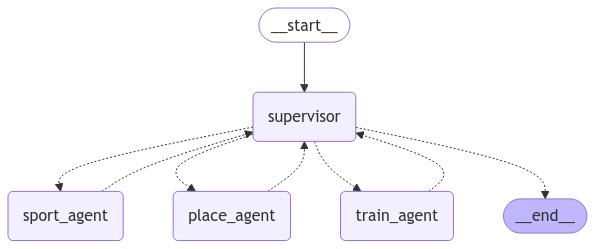

In [27]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

# Test

In [63]:
for s in graph.stream({"messages": [("user", 'What\'s the age of Sean Manaea?')]}, subgraphs=True):
    print(s)
    print("----")

((), {'supervisor': {'next': 'sport_agent'}})
----
(('sport_agent:95a81489-32c5-48e9-d8fe-c920d2073b96',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OfUXzrA5aMEsfvLN23olcAt9', 'function': {'arguments': '{}', 'name': 'get_players'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 75, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a48fe906-c02b-4105-90c5-06edd22177d6-0', tool_calls=[{'name': 'get_players', 'args': {}, 'id': 'call_OfUXzrA5aMEsfvLN23olcAt9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 75, 'output_tokens': 11, 'total_tokens': 86, 'inpu

In [65]:
for s in graph.stream({"messages": [("user", 'What\'s the completion year of Pyramids of Giza')]}, subgraphs=True):
    print(s)
    print("----")

((), {'supervisor': {'next': 'place_agent'}})
----
(('place_agent:d84d9eeb-2641-46dc-a836-b6f173e1a02e',), {'agent': {'messages': [AIMessage(content='The Pyramids of Giza were completed around 2560 BC. The Great Pyramid, which is the largest of the three pyramids, is believed to have taken about 20 years to construct, finishing during the reign of Pharaoh Khufu (also known as Cheops).', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 71, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'stop', 'logprobs': None}, id='run-a090f8c3-276a-4fb7-a3c7-b56d82198823-0', usage_metadata={'input_tokens': 71, 'output_tokens': 58, 'total_tokens': 129, 'input_token_de

In [64]:
for s in graph.stream({"messages": [("user", 'What\'s the the engine used in locomotive M9?')]}, subgraphs=True):
    print(s)
    print("----")

((), {'supervisor': {'next': 'train_agent'}})
----
(('train_agent:804cfdbd-a9e7-0077-7f07-526076d20973',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_C9GwC9RfQvrI3Ni0V24AJ2bJ', 'function': {'arguments': '{}', 'name': 'get_trains'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 89, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-03f58f1e-8f74-4bfc-8fb4-a1813cf49b7e-0', tool_calls=[{'name': 'get_trains', 'args': {}, 'id': 'call_C9GwC9RfQvrI3Ni0V24AJ2bJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 89, 'output_tokens': 12, 'total_tokens': 101, 'inpu